# BC observed positive: estimation of $\epsilon$ MLE

In this case, consider:
- $e$ the list of interaction. Latent.
- $\hat{e}$ the list of observed interactions. Observed. This variable contains only the information that some pairs of nodes $\hat{e}_k$ have interacted. It does not say anything about the sign of the interaction
- $s$ the list of signs. Observed. For every $k$, we know $s_k$.
- $\epsilon$ latent parameter. The quantity we want to estimate.

In this notebook we compute $\epsilon$ by minimizing the following loss

$\mathcal{L}(\epsilon) = - \log L(\epsilon, s) = \sum\limits_{j: s_j = 1} \log \kappa_{\epsilon}(\hat{e}_j) + \sum\limits_{j: s_j = 0} \log \sum\limits_{e \in V^2} (1 - \kappa_{\epsilon}(e)) P(e)$

In [10]:
import torch
import torch.nn as nn
import numpy as np
from scipy.special import expit as sigmoid
import sys
sys.path += ['../src/']
import pandas as pd
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
import jax.numpy as jnp
from importlib import reload
import matplotlib.pyplot as plt
from time import time
from scipy.special import logit
from tqdm import tqdm
from nodes_interactor import NodesInteractor
from initialize_model import EarlyStopping,RandomizeEpsilon,choose_optimizer

In [2]:
class BC_observed_positive(nn.Module): #PyTorch model for gradient optimization, for estimating epsilon observing edges and x0
    
    def __init__(self, epsilon0 = 0.1):
        
        super().__init__()
        theta = torch.tensor([logit(epsilon0)], requires_grad = True) # initialize weights with epsilon0
        self.theta = nn.Parameter(theta)     #define the parameters of the model
    
    def forward(self):
        epsilon = torch.sigmoid(self.theta) #at each step clip epsilon in the interval [0,1]
        return epsilon

In [171]:
def tot_log_likelihood_observe_only_positive(X, edges, T, N, edge_per_t, epsilon, rho = 70, sample_pairs = 100):
    uvst = sim_bc.convert_edges_uvst(edges)
    u,v,s,t = positive_edges = uvst[:, uvst[2,:] == 1]
    
    diff_X_positive = torch.abs(X[t,u] - X[t,v])

    log_likelihood_observed = torch.sum(torch.log(torch.sigmoid(rho * (epsilon - diff_X_positive))))

    u_sample, v_sample = torch.randint(N, (T, sample_pairs, 2)).T
    abs_diff_sample_X = torch.abs(torch.gather(X, 1, u_sample.T) - torch.gather(X, 1, v_sample.T))
    kappa_neg = torch.sigmoid(-rho * (epsilon - abs_diff_sample_X))[:-1]
    n_negative_interactions = edge_per_t - edges.sum(axis = 1)[:,2]
    
    #log_likelihood_non_observed = torch.sum(kappa_neg.mean(axis = 1) * (n_negative_interactions))
    log_likelihood_non_observed = torch.sum(n_negative_interactions * torch.log(kappa_neg.mean(axis = 1)))
     
    neg_tot_log_likelihood = - log_likelihood_observed - log_likelihood_non_observed
    
    return neg_tot_log_likelihood

In [172]:
def estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                             num_epochs = 50, optimizer_name = "adam", 
                             lr = 0.01, forward = "epsilon", hide_progress = False, 
                             min_delta = 1e-5, patience = 5, return_time = False, min_epochs = 20):
    t0 = time()
    history = {"epsilon": [epsilon0], "loss": [], "grad": []} #return the lists of the epsilon estimates and losses 

    T, N = X.size()
    
    _, edge_per_t, _ = edges.size()
    
    early_stopping = EarlyStopping(patience, min_delta, min_epochs)
    model_class = BC_observed_positive
    model = model_class(epsilon0)
    
    optimizer = choose_optimizer(optimizer_name, lr, model) #input the optimizer and learning rate, among SGD, adam, adagrad, nadam
    
    for epoch in tqdm(range(num_epochs), disable = hide_progress):
        epsilon = model()
        #loss = tot_neg_log_likelihood(edges, epsilon, mu, rho, X, with_nodes_interactor = False)
        loss = tot_log_likelihood_observe_only_positive(X, edges, T, N, edge_per_t, epsilon, sample_pairs = 100)
        loss.backward()
        optimizer.step()
        
        
        history["epsilon"].append(sigmoid(model.theta.item()))
        history["loss"].append(loss.item())
        history["grad"].append(model.theta.grad.item())
        
        # early stopping
        
        early_stopping(history["epsilon"][-1], history["epsilon"][-2], epoch)
        if early_stopping.early_stop:
            break
        
        
        optimizer.zero_grad()
        
    t1 = time()
    if return_time:
        history["time"] = t1 - t0
    return history

In [173]:
N, T, edge_per_t = 50, 1000, 4
rho = 70
epsilon,mu, epsilon0 = 0.37, 0.7, 0.3

X, edges = sim_bc.simulator_stoch(N,T,edge_per_t,epsilon,mu,rho)

In [174]:
loss_closure = lambda x: tot_log_likelihood_observe_only_positive(X, edges, T, N, edge_per_t, x, sample_pairs = 50).item()

In [175]:
loss_epsilons = pd.DataFrame([((eps, loss_closure(eps))) for eps in np.arange(0, 0.5, 0.01)], columns = ["epsilon", "loss"])

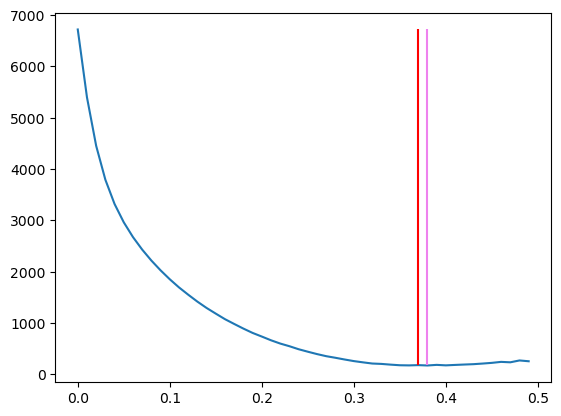

In [176]:
plt.plot(loss_epsilons["epsilon"], loss_epsilons["loss"])
plt.vlines(x = epsilon, ymin = loss_epsilons["loss"].min(), ymax = loss_epsilons["loss"].max(), colors = "red")
plt.vlines(x = loss_epsilons.sort_values("loss")["epsilon"].iloc[0], 
           ymin = loss_epsilons["loss"].min(), ymax = loss_epsilons["loss"].max(), colors = "violet")

In [177]:
history = estimation_epsilon_torch(X, edges, mu, num_epochs = 500)

 32%|█████████████                            | 160/500 [01:18<02:46,  2.04it/s]


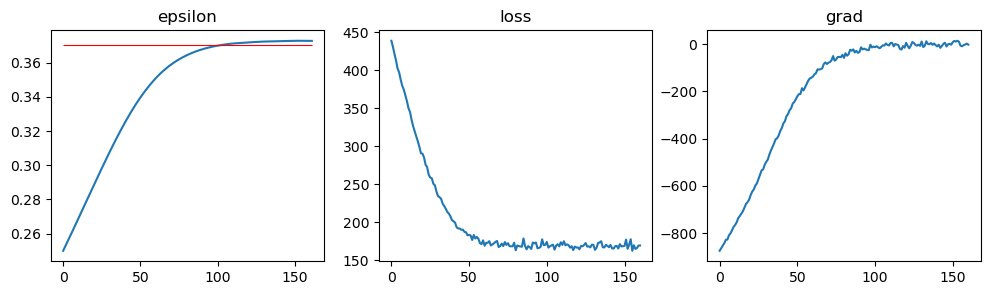

In [178]:
est_bc.print_history(history, epsilon)

In [179]:
epsilon, history["epsilon"][-1]

(0.37, 0.37267856932744553)